# Siamese Network
Network for a Face Recognition System

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Dataset

## Utility Functions

In [2]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

## Prepare Data

In [4]:
# Get the data directory paths
faces = "C:/Users/Research/Downloads/SIAMESE/olivetti_faces.npy"
faces_targets = "C:/Users/Research/Downloads/SIAMESE/olivetti_faces_target.npy"

In [5]:
# Load the images and labels
face_images = np.load(faces)
face_labels = np.load(faces_targets)

In [6]:
target_shape = face_images[0].shape

In [7]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [8]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

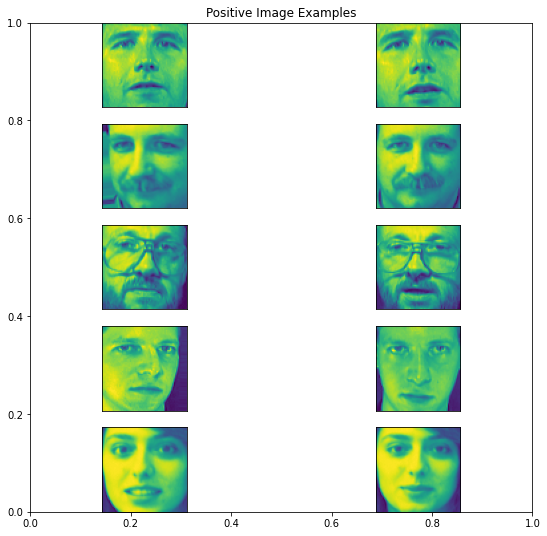

In [9]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

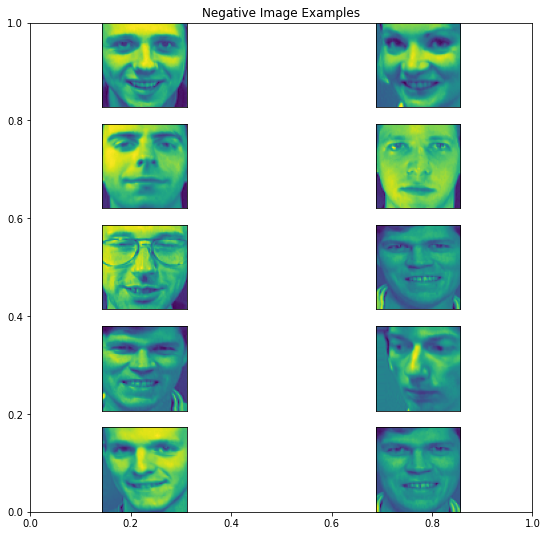

In [10]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

# Network Architecture

## Embedding Layer

In [11]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

## Siamese Network

In [12]:
import tensorflow.keras.backend as K

In [13]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [14]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [15]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

# Training

In [16]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 52s 5s/step - loss: 0.6868 - accuracy: 0.4891 - val_loss: 0.6319 - val_accuracy: 0.6187
Epoch 2/150
10/10 [==============================] - 47s 5s/step - loss: 0.6710 - accuracy: 0.4891 - val_loss: 0.5974 - val_accuracy: 0.6187
Epoch 3/150
10/10 [==============================] - 48s 5s/step - loss: 0.6453 - accuracy: 0.4891 - val_loss: 0.5851 - val_accuracy: 0.6250
Epoch 4/150
10/10 [==============================] - 48s 5s/step - loss: 0.6380 - accuracy: 0.4891 - val_loss: 0.5940 - val_accuracy: 0.6250
Epoch 5/150
10/10 [==============================] - 47s 5s/step - loss: 0.6317 - accuracy: 0.4906 - val_loss: 0.5903 - val_accuracy: 0.6375
Epoch 6/150
10/10 [==============================] - 47s 5s/step - loss: 0.6229 - accuracy: 0.4906 - val_loss: 0.5898 - val_accuracy: 0.6313
Epoch 7/150
10/10 [==============================] - 47s 5s/step - loss: 0.6346 - accuracy: 0.4953 - val_loss: 0.5859 - val_accuracy: 0.6313
Epoch 8/150
1

Epoch 59/150
10/10 [==============================] - 48s 5s/step - loss: 0.4237 - accuracy: 0.8500 - val_loss: 0.6653 - val_accuracy: 0.6812
Epoch 60/150
10/10 [==============================] - 47s 5s/step - loss: 0.4321 - accuracy: 0.8438 - val_loss: 0.5437 - val_accuracy: 0.7688
Epoch 61/150
10/10 [==============================] - 47s 5s/step - loss: 0.4250 - accuracy: 0.8703 - val_loss: 0.6456 - val_accuracy: 0.7000
Epoch 62/150
10/10 [==============================] - 47s 5s/step - loss: 0.4310 - accuracy: 0.8500 - val_loss: 0.6048 - val_accuracy: 0.7812
Epoch 63/150
10/10 [==============================] - 47s 5s/step - loss: 0.4266 - accuracy: 0.8703 - val_loss: 0.5925 - val_accuracy: 0.7375
Epoch 64/150
10/10 [==============================] - 47s 5s/step - loss: 0.4403 - accuracy: 0.8484 - val_loss: 0.5148 - val_accuracy: 0.8000
Epoch 65/150
10/10 [==============================] - 47s 5s/step - loss: 0.4399 - accuracy: 0.8484 - val_loss: 0.5147 - val_accuracy: 0.7750
Epoch 

10/10 [==============================] - 47s 5s/step - loss: 0.2552 - accuracy: 0.9547 - val_loss: 0.6567 - val_accuracy: 0.7563
Epoch 117/150
10/10 [==============================] - 48s 5s/step - loss: 0.2478 - accuracy: 0.9703 - val_loss: 0.7093 - val_accuracy: 0.7563
Epoch 118/150
10/10 [==============================] - 47s 5s/step - loss: 0.2591 - accuracy: 0.9563 - val_loss: 0.4661 - val_accuracy: 0.8375
Epoch 119/150
10/10 [==============================] - 47s 5s/step - loss: 0.2807 - accuracy: 0.9516 - val_loss: 0.7570 - val_accuracy: 0.7625
Epoch 120/150
10/10 [==============================] - 47s 5s/step - loss: 0.2536 - accuracy: 0.9609 - val_loss: 0.7028 - val_accuracy: 0.7625
Epoch 121/150
10/10 [==============================] - 47s 5s/step - loss: 0.2610 - accuracy: 0.9531 - val_loss: 0.5620 - val_accuracy: 0.7812
Epoch 122/150
10/10 [==============================] - 48s 5s/step - loss: 0.2531 - accuracy: 0.9578 - val_loss: 0.4616 - val_accuracy: 0.8375
Epoch 123/150

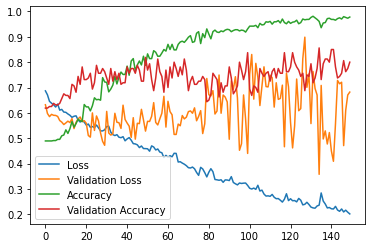

In [17]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

# Testing

In [18]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

## Test 1

In [19]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

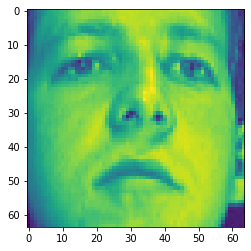

In [20]:
plt.imshow(test_image)

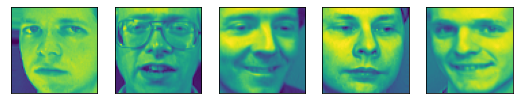

In [21]:
test_visualize(compare_images)

In [22]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [23]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [24]:
print(score)

[[0.08324027]
 [0.18910468]
 [0.00283009]
 [0.00173029]
 [0.00505605]]


## Test 2

In [25]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

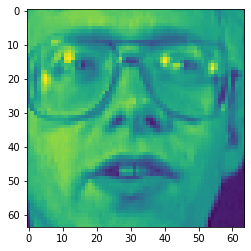

In [26]:
plt.imshow(test_image)

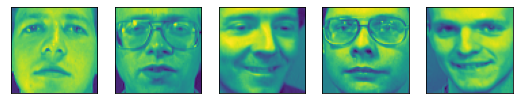

In [27]:
test_visualize(compare_images)

In [28]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [29]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [30]:
print(score)

[[0.30167228]
 [0.35609955]
 [0.00109765]
 [0.00092986]
 [0.00167391]]


In [31]:
import tensorflow as tf
tf.keras.models.save_model("siammodel")

In [37]:

siamese_model.save("C:/Users/Research/Downloads/SIAMESE/siameseface")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/Research/Downloads/SIAMESE/siameseface\assets
